In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import snapfish2
snapfish2.MulFish.default_cols.extend(["Replicate", "FOV"])

- optimal weights
- chromtic aberrations
- global background
- ground truth
- comments & documentations
- differential interaction
- live cell

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
np.random.seed(100)

In [4]:
data_dire = "../data/takei_nature_2021"
rep_paths = ["4DNFIHF3JCBY.csv", "4DNFIQXONUUH.csv"]
mfrs = []
for i, rep_path in enumerate(rep_paths):
    path = os.path.join(data_dire, rep_path)
    mfrs.append(snapfish2.MulFish(path))
    # Extract FOV ID
    mfrs[-1].data["FOV"] = mfrs[-1].data["Cell_ID"].str.extract(r"(\d+)\_\d+")
    # Add replicate ID to Trace_ID and as a separate column
    mfrs[-1].data["Trace_ID"] = f"{i}_" + mfrs[-1].data["Trace_ID"]
    mfrs[-1].data["Replicate"] = f"rep{i}"
    # Convert voxel coordinates to nm
    mfrs[-1].data["X"] *= 103
    mfrs[-1].data["Y"] *= 103
    mfrs[-1].data["Z"] *= 250
concat_df = pd.concat([m.data for m in mfrs])
mfr = snapfish2.MulFish(concat_df)

<Axes: xlabel='locus', ylabel='Z'>

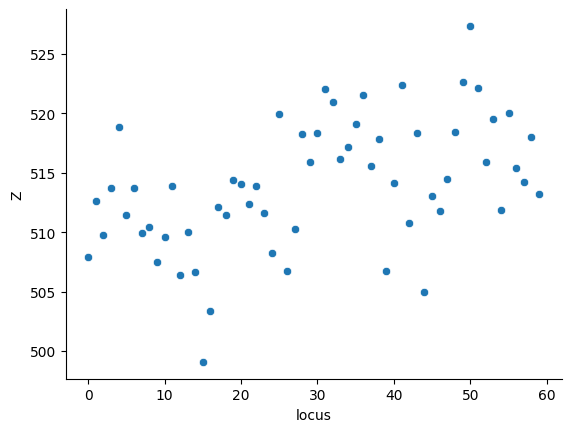

In [11]:
df = mfr[("FOV", 3), ("Replicate", 0)].copy()
plt_df = df.groupby("locus")["Z"].mean().reset_index()
sns.scatterplot(plt_df, x="locus", y="Z")

In [13]:
df

,Trace_ID,Chrom_Start,Spot_ID,X,Y,Z,Chrom,Chrom_End,Cell_ID,Extra_Cell_ROI_ID,locus,FOV,Replicate
16380,0_3_1_1_0,135600000,NaN,NaN,NaN,NaN,chr1,135625000,3_1,NaN,0,3,rep0
16381,0_3_1_1_0,135625000,899950.0,14191.134,1669.321,379.75,chr1,135650000,3_1,3.0,1,3,rep0
16382,0_3_1_1_0,135650000,NaN,NaN,NaN,NaN,chr1,135675000,3_1,NaN,2,3,rep0
16383,0_3_1_1_0,135675000,899951.0,14199.580,1674.574,356.75,chr1,135700000,3_1,3.0,3,3,rep0
16384,0_3_1_1_0,135700000,899952.0,14197.108,1682.711,379.00,chr1,135725000,3_1,3.0,4,3,rep0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495115,0_3_41_20_0,76900457,NaN,NaN,NaN,NaN,chrX,76925457,3_41,NaN,55,3,rep0
495116,0_3_41_20_0,76925457,NaN,NaN,NaN,NaN,chrX,76950457,3_41,NaN,56,3,rep0
495117,0_3_41_20_0,76950457,NaN,NaN,NaN,NaN,chrX,76975457,3_41,NaN,57,3,rep0
495118,0_3_41_20_0,76975457,965763.0,17461.796,6225.320,501.00,chrX,77000457,3_41,3.0,58,3,rep0


<Axes: xlabel='Chrom_Start', ylabel='Z'>

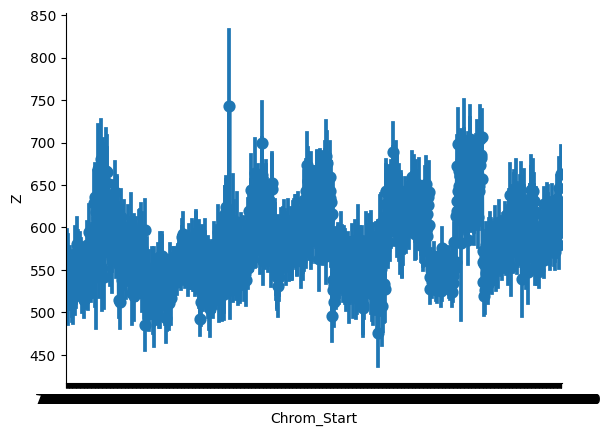

In [6]:
sns.pointplot(df, x="Chrom_Start", y="Z", errorbar="se")

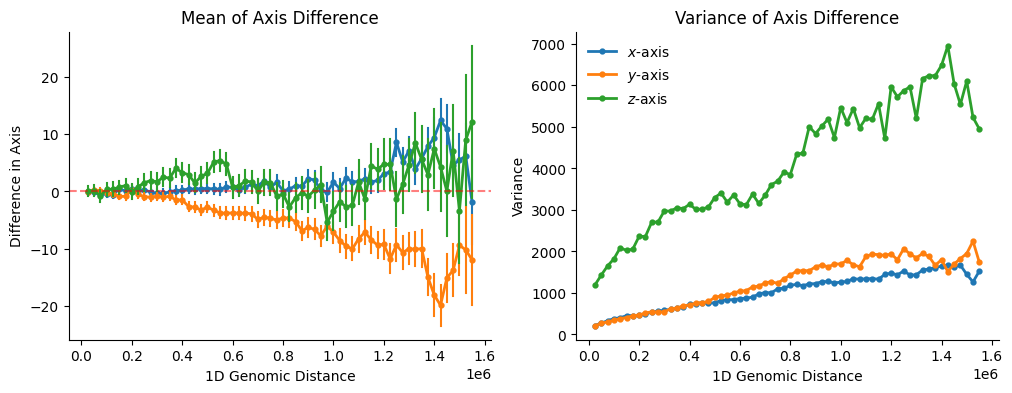

In [14]:
a, arrs = snapfish2.utils.to_very_wide(mfrs[0][("Chrom","chr2"), ("FOV", "0")])
d1d = a.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arrs)

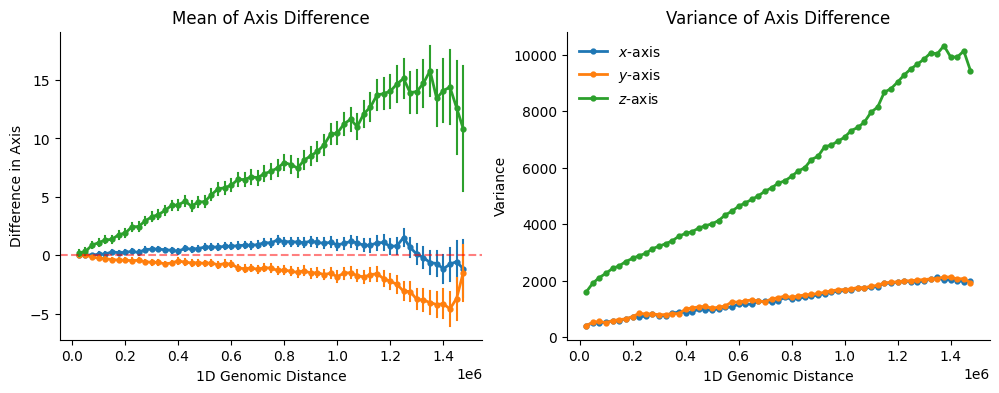

In [7]:
a, arrs = snapfish2.utils.to_very_wide(mfr["chr1"])
d1d = a.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arrs)

In [6]:
noised = mfr.data.copy()
# noised["X"] += stats.norm.rvs(size=(len(mfr.data["X"])), scale=50)
# noised["Y"] += stats.norm.rvs(size=(len(mfr.data["Y"])), scale=50)
noised["Z"] += stats.norm.rvs(size=(len(mfr.data["Z"])), scale=50)
slc = snapfish2.loop.caller.LoopCaller(noised)

very same


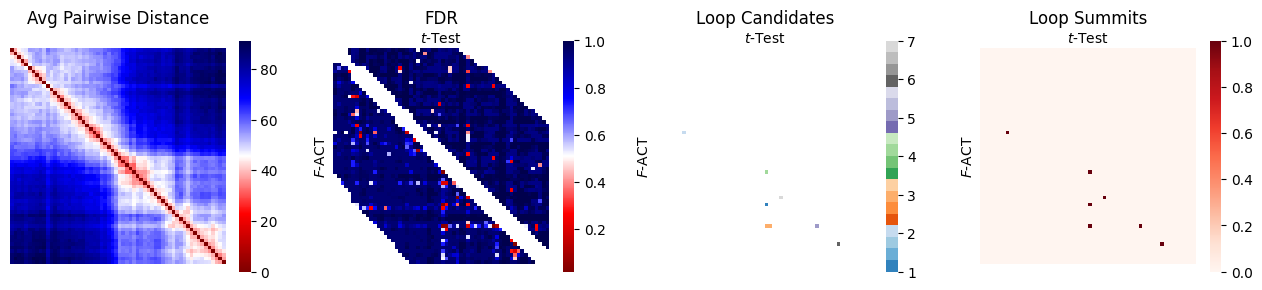

In [7]:
chr_id = "chr3"
chr_df, arr = snapfish2.utils.to_very_wide(mfr[chr_id])
dmaps = np.sqrt(np.sum(np.square(arr), axis=1))
result = slc.loops_from_single_reg(chr_id)
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
t1, t2, x, y = result["t_test"], result["f_act_test"], r"$t$-Test", r"$F$-ACT"
snapfish2.plot.pairwise_heatmap(dmaps, title=f"Avg Pairwise Distance", x=" ", ax=axes[0])
snapfish2.plot.pairwise_heatmap(X1=t1["fdr"], X2=t2["fdr"], x=x, y=y, title="FDR", ax=axes[1])
snapfish2.plot.pairwise_heatmap(X1=t1["labeled"], X2=t2["labeled"], x=x, y=y, title="Loop Candidates", cmap="tab20c", ax=axes[2])
snapfish2.plot.pairwise_heatmap(X1=t1["summit"], X2=t2["summit"], x=x, y=y, title="Loop Summits", cmap="Reds", ax=axes[3])

### Distribution analysis

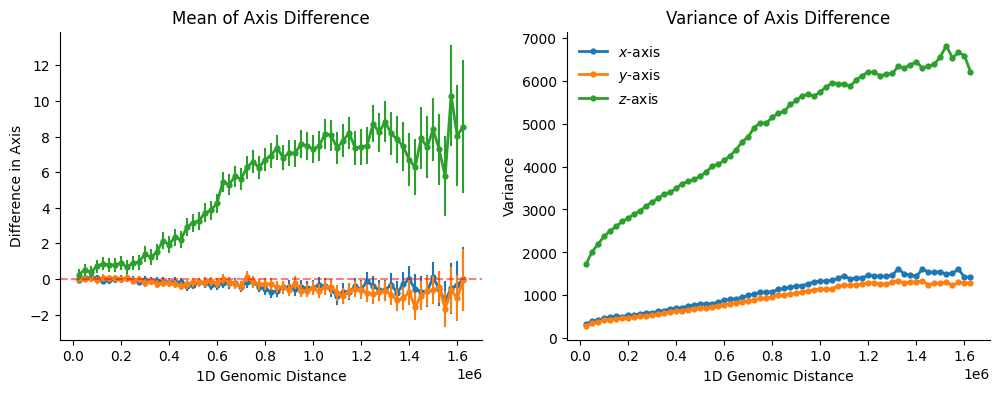

In [8]:
a, arrs = snapfish2.utils.to_very_wide(mfr[chr_id])
d1d = a.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arrs)

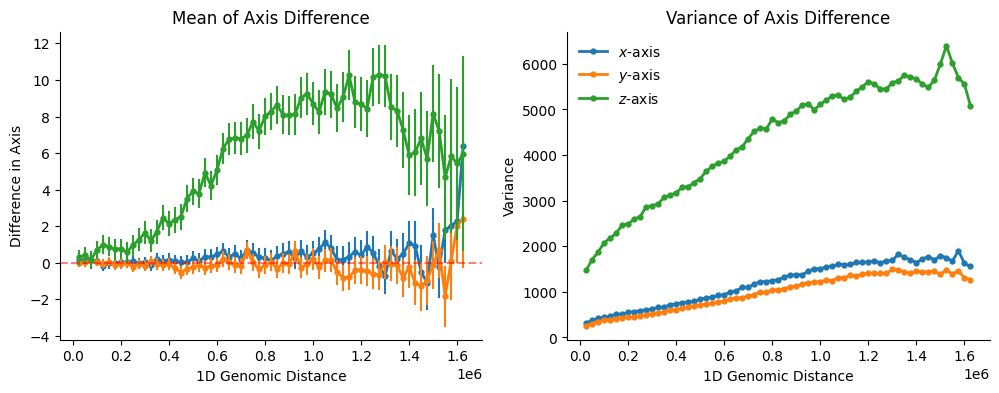

In [9]:
a, arrs = snapfish2.utils.to_very_wide(mfr[chr_id,:,"rep0"])
d1d = a.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arrs)

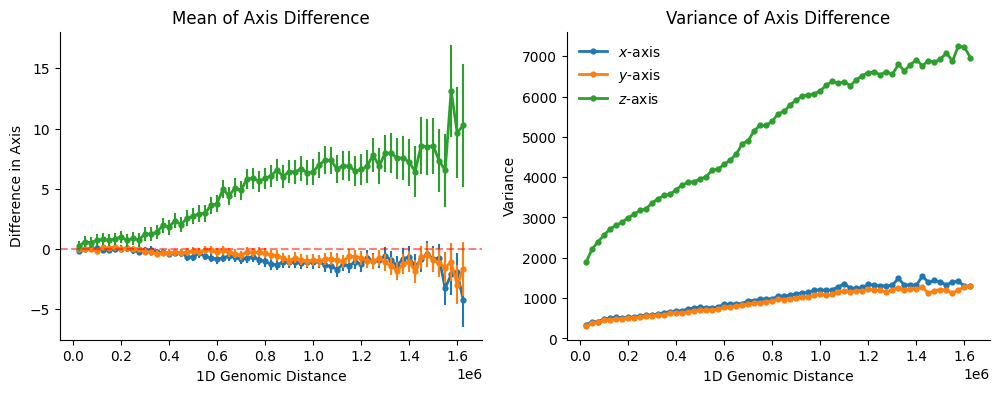

In [10]:
a, arrs = snapfish2.utils.to_very_wide(mfr[chr_id,:,"rep1"])
d1d = a.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arrs)

In [34]:
mfr[("FOV","0","5",1)]

,Trace_ID,Chrom_Start,Spot_ID,X,Y,Z,Chrom,Chrom_End,Cell_ID,Extra_Cell_ROI_ID,locus,FOV,Replicate
0,0_0_1_1_0,135600000,NaN,NaN,NaN,NaN,chr1,135625000,0_1,NaN,0,0,rep0
1,0_0_1_1_0,135625000,705144.0,18230.794,1558.596,705.25,chr1,135650000,0_1,0.0,1,0,rep0
2,0_0_1_1_0,135650000,705145.0,18226.159,1550.768,692.75,chr1,135675000,0_1,0.0,2,0,rep0
3,0_0_1_1_0,135675000,NaN,NaN,NaN,NaN,chr1,135700000,0_1,NaN,3,0,rep0
4,0_0_1_1_0,135700000,705147.0,18227.395,1558.493,647.75,chr1,135725000,0_1,0.0,4,0,rep0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603415,1_4_38_20_0,76900457,NaN,NaN,NaN,NaN,chrX,76925457,4_38,NaN,55,4,rep1
603416,1_4_38_20_0,76925457,NaN,NaN,NaN,NaN,chrX,76950457,4_38,NaN,56,4,rep1
603417,1_4_38_20_0,76950457,1502703.0,3479.958,3100.094,608.75,chrX,76975457,4_38,4.0,57,4,rep1
603418,1_4_38_20_0,76975457,1502704.0,3497.365,3090.618,608.75,chrX,77000457,4_38,4.0,58,4,rep1


In [24]:
df = mfr["chr1",:,0,0].copy()
df

0
1
2
3


,Trace_ID,Chrom_Start,Spot_ID,X,Y,Z,Chrom,Chrom_End,Cell_ID,Extra_Cell_ROI_ID,locus,FOV,Replicate
0,0_0_1_1_0,135600000,NaN,NaN,NaN,NaN,chr1,135625000,0_1,NaN,0,0,rep0
1,0_0_1_1_0,135625000,705144.0,18230.794,1558.596,705.25,chr1,135650000,0_1,0.0,1,0,rep0
2,0_0_1_1_0,135650000,705145.0,18226.159,1550.768,692.75,chr1,135675000,0_1,0.0,2,0,rep0
3,0_0_1_1_0,135675000,NaN,NaN,NaN,NaN,chr1,135700000,0_1,NaN,3,0,rep0
4,0_0_1_1_0,135700000,705147.0,18227.395,1558.493,647.75,chr1,135725000,0_1,0.0,4,0,rep0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,0_0_46_1_1,136975000,771157.0,12406.762,10914.601,606.50,chr1,137000000,0_46,0.0,55,0,rep0
5936,0_0_46_1_1,137000000,771159.0,12400.891,10906.979,556.50,chr1,137025000,0_46,0.0,56,0,rep0
5937,0_0_46_1_1,137025000,771161.0,12392.960,10913.365,545.50,chr1,137050000,0_46,0.0,57,0,rep0
5938,0_0_46_1_1,137050000,771163.0,12395.123,10922.120,573.25,chr1,137075000,0_46,0.0,58,0,rep0


In [50]:
axis = 0
ff = d1d[:,None] - d1d[None,:] == 25e4
aa = np.stack([arrs1[:,axis,ff], arrs2[:,axis,ff]])
# np.all(~np.isnan(aa[:,:,axis,:]), axis=0).shape
uidx = np.triu_indices_from(aa[0,:,:])
aa_fla = aa[:,*uidx]


(2, 1176)

In [51]:
aa.shape

(2, 408, 48)

Unrealistic outliers: `dx`=400 will imply the distance is at least 40000 nm, or 40 um, which is unrealistic. Keep the central 98%.

<Axes: xlabel='Difference in Axis', ylabel='1D Genomic Distance'>

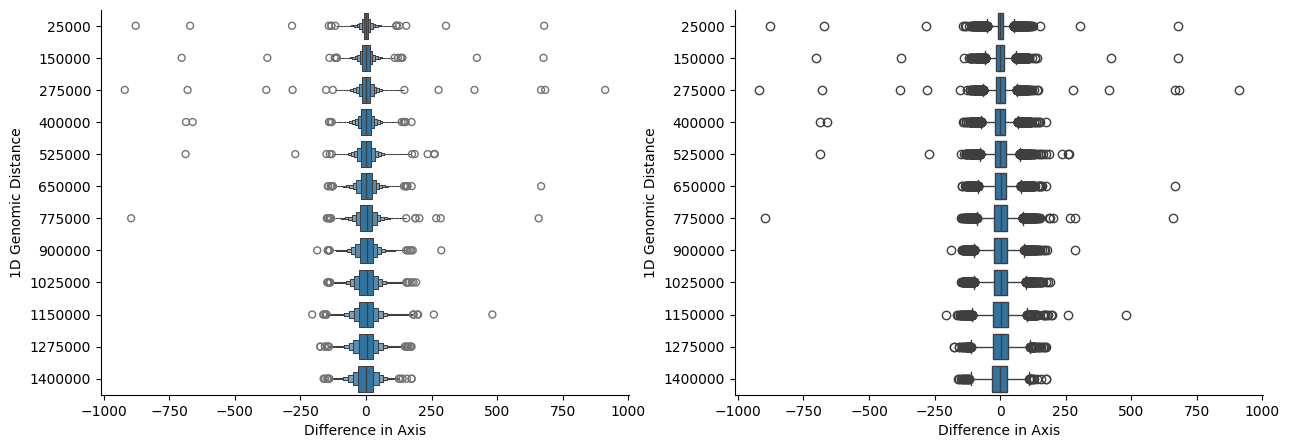

In [9]:
df = daxis_df[daxis_df.Axis=="$x$-axis"]
sele_1d = np.unique(df["1D Genomic Distance"])[::5]
df = df[df["1D Genomic Distance"].isin(sele_1d)]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxenplot(df, x="Difference in Axis", y="1D Genomic Distance", orient="h", ax=axes[0])
sns.boxplot(df, x="Difference in Axis", y="1D Genomic Distance", orient="h", whis=(1, 99), ax=axes[1])

In [10]:
sr = daxis_df.groupby(
    ["Axis", "1D Genomic Distance"], sort=False
)["Difference in Axis"].apply(
    lambda x: np.percentile(x, [1, 99])
).reset_index().set_index(["1D Genomic Distance"])
sr[["l", "u"]] = np.stack(sr["Difference in Axis"].values)

perc_filters = []
d1map = np.abs(d1d[:,None] - d1d[None,:])
for _, df in sr.groupby("Axis", sort=False):
    l_map = np.zeros_like(d1map)*np.nan
    u_map = np.zeros_like(d1map)*np.nan
    uidx = np.triu_indices_from(d1map, 1)
    
    l_map[uidx] = df.loc[d1map[uidx]]["l"]
    l_map.T[uidx] = l_map[uidx]
    u_map[uidx] = df.loc[d1map[uidx]]["u"]
    u_map.T[uidx] = u_map[uidx]
    perc_filters.append([l_map, u_map])
perc_filters = np.stack(perc_filters)

farrs = arrs.copy()
for i in range(farrs.shape[1]):
    l_filter = farrs[:,i,:,:] < perc_filters[i][0]
    u_filter = farrs[:,i,:,:] > perc_filters[i][1]
    farrs[:,i,:,:] = np.where(l_filter|u_filter, np.nan, farrs[:,i,:,:])

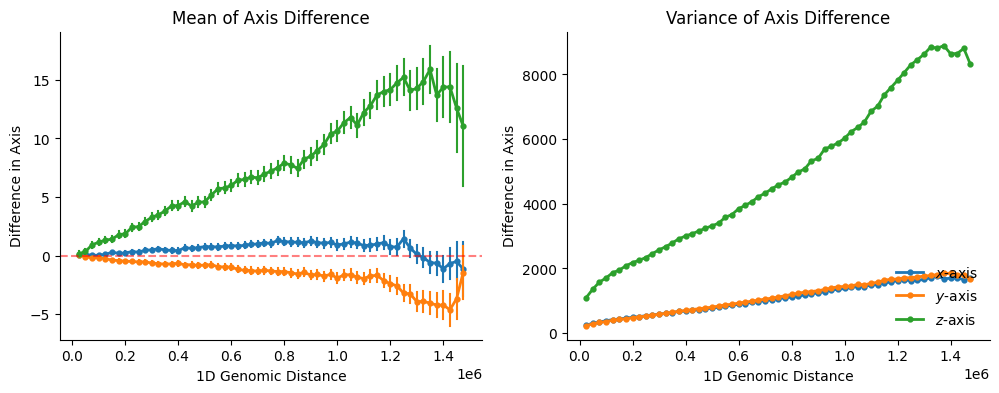

In [11]:
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, farrs)

<Axes: xlabel='Difference in Axis', ylabel='1D Genomic Distance'>

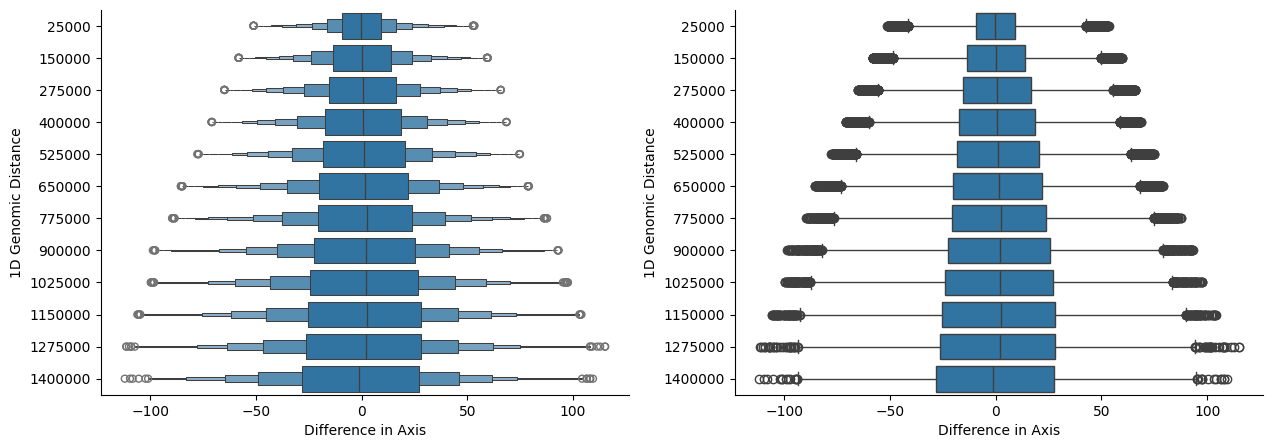

In [12]:
df = daxis_df[daxis_df.Axis=="$x$-axis"]
sele_1d = np.unique(df["1D Genomic Distance"])[::5]
df = df[df["1D Genomic Distance"].isin(sele_1d)]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxenplot(df, x="Difference in Axis", y="1D Genomic Distance", orient="h", ax=axes[0])
sns.boxplot(df, x="Difference in Axis", y="1D Genomic Distance", orient="h", whis=(1, 99), ax=axes[1])

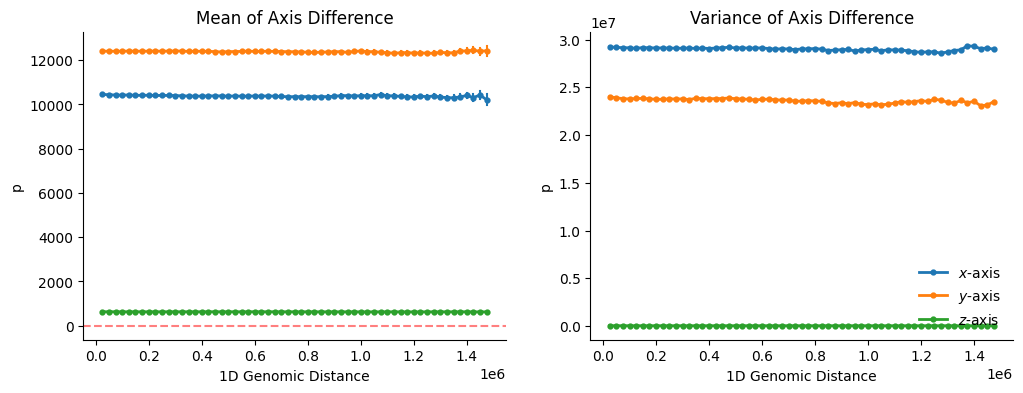

In [13]:
parrs = snapfish2.utils.to_very_wide(mfr[chr_id], lambda a,b:(a+b)/2)[1]
fig, paxis_df = snapfish2.plot.daxis_dist(d1d, parrs, ylab="p")

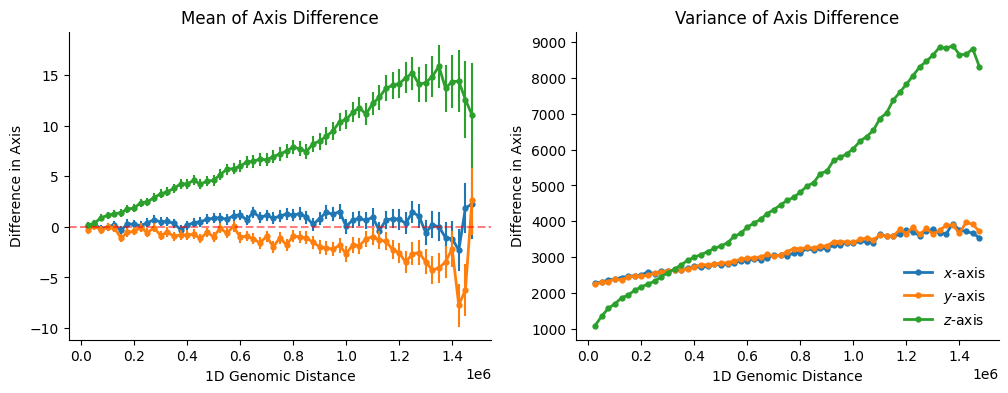

In [14]:
narrs = farrs.copy()
size = (farrs.shape[0], farrs.shape[2], farrs.shape[3])
narrs[:,0,:,:] += stats.norm.rvs(size=size, scale=45)
narrs[:,1,:,:] += stats.norm.rvs(size=size, scale=45)
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, narrs)

In [38]:
X = np.array([
    [2, 1, 1],
    [1, 2, 1],
    [1, 1, 2]
])
np.identity(3) - np.linalg.inv(X)

array([[0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25]])